In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def higher_order_regression(data, m): # function to perform higher order regression using matrix multiplicaton 
    X = data['x'].values
    Y = data['y'].values

    def polynomial_features(X, degree):
        X_poly = np.ones((X.shape[0], degree + 1)) 
        for d in range(1, degree + 1):
            X_poly[:, d] = X ** d
        return X_poly

    X_poly = polynomial_features(X, m)
    
    # solving for β using the equation: β = (X^T * X)^(-1) * X^T * Y
    XTX = np.dot(X_poly.T, X_poly)
    XTY = np.dot(X_poly.T, Y)
    beta_hat = np.linalg.solve(XTX, XTY)
    
    return beta_hat

    Degree      SSR_Train  R2_Train        SSR_Val    R2_Val
0        1  499593.983909  0.733369  170329.846490  0.722588
1        2  433593.569364  0.768622  148518.952766  0.758555
2        3  296042.063053  0.841902  102085.414234  0.832420
3        4  184556.946630  0.901444   62586.046367  0.897516
4        5  176441.484626  0.905777   59810.615845  0.902064
5        6  176080.870837  0.905973   59970.102075  0.901837
6        7  175911.257462  0.906066   60355.770361  0.901266
7        8  175747.414422  0.906154   60693.862618  0.900710
8        9  174164.717026  0.907007   60977.228180  0.900386
9       10  174051.817501  0.907065   61090.562817  0.900171
10      11  173713.726535  0.907241   61908.187989  0.898707
11      12  172491.494153  0.907867   64538.888277  0.893509
12      13  172177.856115  0.908035   64423.738730  0.893848
13      14  171467.313631  0.908425   64239.338126  0.894240
14      15  171190.043300  0.908575   64356.559112  0.894012
15      16  169100.96280

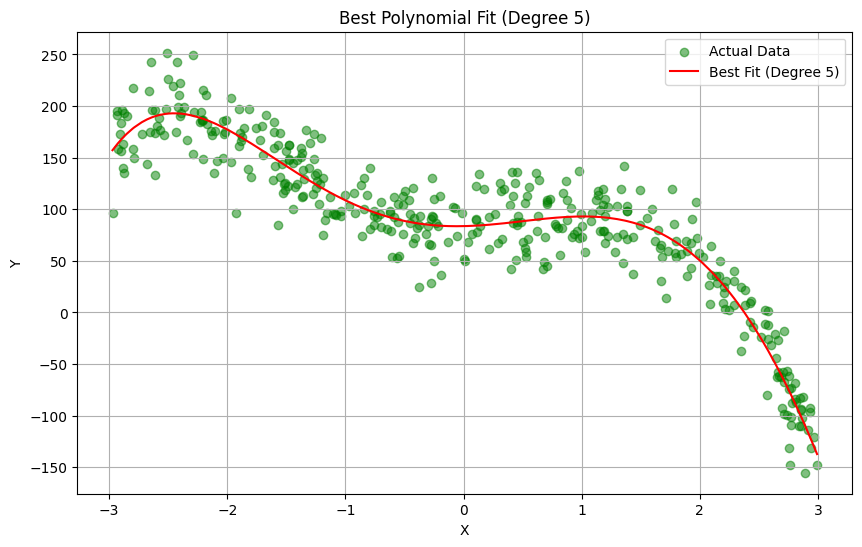

In [23]:
from sklearn.model_selection import KFold # used for cross validation
def cross_validate(data, degrees, k=5): 
    X = data['x'].values
    Y = data['y'].values
    kf = KFold(n_splits=k, shuffle=True, random_state=69)
    results = []
    for m in degrees: # checking for all degrees from 1 to 25
        ssr_train_list, ssr_val_list, r2_train_list, r2_val_list = [], [], [], []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            Y_train, Y_val = Y[train_index], Y[val_index]
            train_data = pd.DataFrame({'x': X_train, 'y': Y_train}) # fit polynomial regression using the higher order regression function
            beta = higher_order_regression(train_data, m)
            X_poly_train = np.column_stack([X_train**i for i in range(m + 1)])
            X_poly_val = np.column_stack([X_val**i for i in range(m + 1)])
            Y_train_pred = np.dot(X_poly_train, beta) # predictions
            Y_val_pred = np.dot(X_poly_val, beta)
            SS_res_train = np.sum((Y_train - Y_train_pred)**2) # calculate SSR and R^2
            SS_res_val = np.sum((Y_val - Y_val_pred)**2)
            SS_tot_train = np.sum((Y_train - np.mean(Y_train))**2)
            SS_tot_val = np.sum((Y_val - np.mean(Y_val))**2)
            r2_train = 1 - (SS_res_train / SS_tot_train)
            r2_val = 1 - (SS_res_val / SS_tot_val)
            ssr_train_list.append(SS_res_train)
            r2_train_list.append(r2_train)
            ssr_val_list.append(SS_res_val)
            r2_val_list.append(r2_val)
        avg_ssr_train = np.mean(ssr_train_list) # averaging over folds
        avg_r2_train = np.mean(r2_train_list)
        avg_ssr_val = np.mean(ssr_val_list)
        avg_r2_val = np.mean(r2_val_list)
        results.append((m, avg_ssr_train, avg_r2_train, avg_ssr_val, avg_r2_val))
    return pd.DataFrame(results, columns=['Degree', 'SSR_Train', 'R2_Train', 'SSR_Val', 'R2_Val'])

data = pd.read_csv('train.csv')
degrees = range(1, 26)  
results_df = cross_validate(data, degrees, k=4)
best_degree = results_df.loc[results_df['R2_Val'].idxmax(), 'Degree']

print(results_df) # print SSr and R^2

best_beta = higher_order_regression(data, best_degree)

X_sorted = np.sort(data['x'].values)
X_poly = np.column_stack([X_sorted**i for i in range(len(best_beta))])
Y_pred = np.dot(X_poly, best_beta)

plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='green', alpha=0.5, label='Actual Data')
plt.plot(X_sorted, Y_pred, color='red', label=f'Best Fit (Degree {best_degree})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Best Polynomial Fit (Degree {best_degree})')
plt.legend()
plt.grid(True)
plt.show()

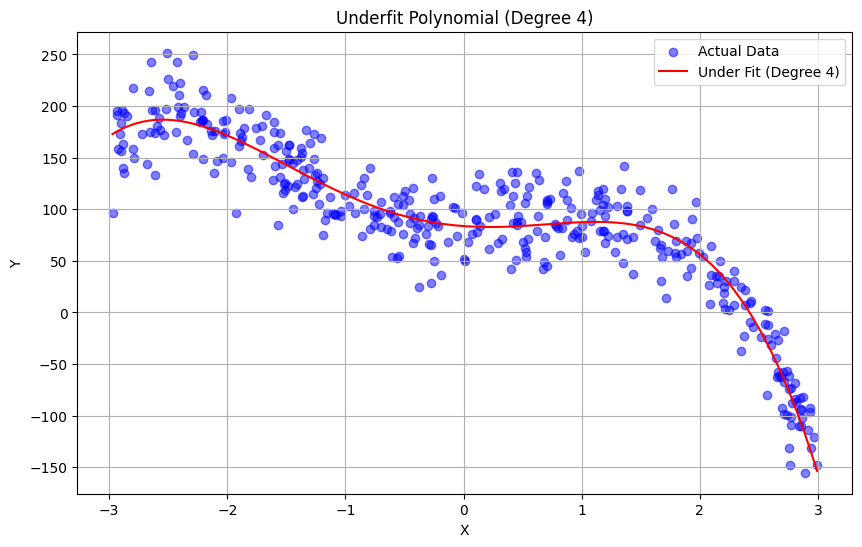

In [24]:
under_beta = higher_order_regression(data, 4)  #plotting underfit curve
X_sorted = np.sort(data['x'].values)
X_poly = np.column_stack([X_sorted**i for i in range(len(under_beta))])
Y_pred = np.dot(X_poly, under_beta)
plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='blue', alpha=0.5, label='Actual Data')
plt.plot(X_sorted, Y_pred, color='red', label=f'Under Fit (Degree {4})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Underfit Polynomial (Degree {4})')
plt.legend()
plt.grid(True)
plt.show()

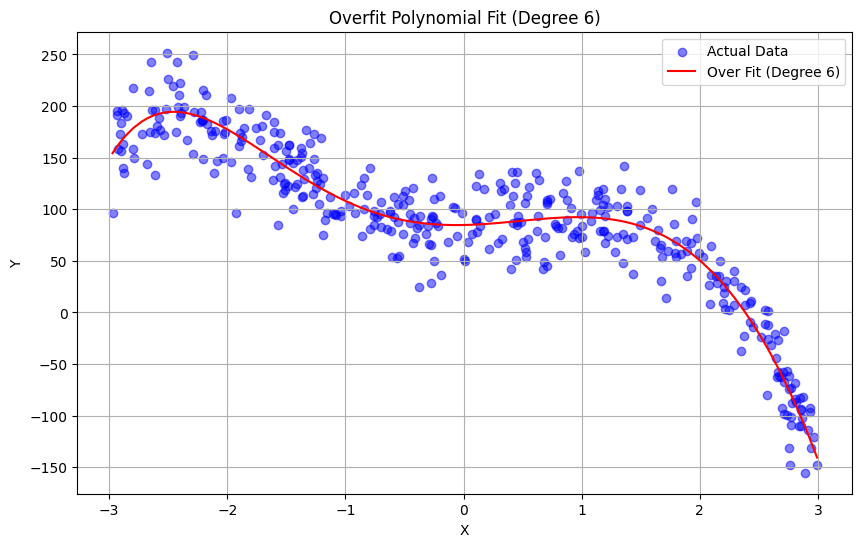

In [25]:
over_beta = higher_order_regression(data, 6) #plotting overfit curve
X_sorted = np.sort(data['x'].values)
X_poly = np.column_stack([X_sorted**i for i in range(len(over_beta))])
Y_pred = np.dot(X_poly, over_beta)
plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='blue', alpha=0.5, label='Actual Data')
plt.plot(X_sorted, Y_pred, color='red', label=f'Over Fit (Degree {6})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Overfit Polynomial Fit (Degree {6})')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
#saving the coeffecients (Beta0, Beta1, ..) in 3_weights.pkl
import pickle
with open('3_weights.pkl', 'wb') as f:
    pickle.dump(best_beta, f)


In [27]:
# Predicting the values for input given in test.csv
test_data = pd.read_csv('test.csv')
X_test = test_data['x'].values
X_poly_test = np.column_stack([X_test**i for i in range(len(best_beta))])
Y_pred_test = np.dot(X_poly_test, best_beta)
output_df = pd.DataFrame({'id': test_data['id'], 'x': test_data['x'], 'y': Y_pred_test })
output_df.to_csv('3_predictions.csv', index=False)

In [28]:
print(best_beta)

[ 83.63591607   2.44833307  20.4101032  -10.82732749  -3.21687742
   0.57237938]
